## Theft Detection Algorithm

This assignment is designed to assess your skills in building a theft detection algorithm using
video data, specifically focusing on shoplifting scenarios.
Dataset: DCSASS Dataset https://www.kaggle.com/datasets/mateohervas/dcsass-dataset
The DCSASS dataset contains a variety of video clips categorized into different activities,
including shoplifting. We will be focusing on videos labeled as "shoplifting" and "normal" to train
our theft detection model.
- Just use videos under shoplifting category
Task:
1. Data Preprocessing: Download the DCSASS dataset and filter for videos labeled as
"shoplifting" and "normal." Preprocess the videos by converting them into a suitable
format for your chosen machine learning model.
2. Feature Engineering: Extract relevant features from the preprocessed videos that can
be used to identify shoplifting activities.
3. Model Building: Develop a machine learning model to classify video frames/clips as
containing shoplifting or not containing shoplifting.
4. Evaluation: Evaluate the performance of your model using relevant metrics like:
○ Accuracy: Overall percentage of correct classifications.
○ Precision: Ratio of true positives (correctly identified shoplifting) to total positive
predictions.
○ Recall: Ratio of true positives to actual shoplifting instances in the dataset.
○ F1 Score: Harmonic mean of precision and recall, balancing both metrics.
5. Report: Prepare a report summarizing your approach, including:
○ Data preprocessing steps and rationale for chosen techniques.
○ Feature engineering methods and their effectiveness in identifying shoplifting.
○ Model selection with justification and hyperparameter tuning (if applicable).
○ Evaluation results, including confusion matrix and chosen metrics.
○ Discussion of strengths, weaknesses, and potential improvements to your
approach.
Deliverables:
● Jupyter Notebook or Python script containing your code
● Report summarizing your methodology, results, and discussion
Evaluation Criteria:
● Clarity and efficiency of code
● Appropriateness of feature engineering techniques
● Model selection and justification
● Performance of the model on the shoplifting detection task
● Communication and insights presented in the report

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import os
import cv2
import shutil

In [2]:

# Organising data
folder_path = "Shoplifting"
folder_names = ["0","1"]

if not os.path.exists(folder_path):
    os.mkdir(folder_path)
else:
    print("Folder already exists...")

for folder_name in folder_names:
    if not os.path.exists(os.path.join(folder_path,folder_name)):
        os.mkdir(os.path.join(folder_path,folder_name))
    else:
        print("folder already exists...")

dataset = pd.read_csv("/kaggle/input/lifting/Shoplifting.csv")

# the datasets column names are also the part of the dataset
# first we will append that data into our dataframe and then rename the columns

data = [dataset.columns[0],dataset.columns[1],int(dataset.columns[2])]

dataset.loc[len(dataset)] = data

dataset.rename(columns={"Shoplifting001_x264_0":"clipname","Shoplifting":"Shoplifting","0":"Action"},inplace=True)

In [3]:
ROOT_DIR = r"D:\Datasets\DCSASS Dataset\Shoplifting"
DESTINATION_ROOT = r"/kaggle/input/shoplifting-detection-dataset/Shoplifting"
DESTINATION_PATH_0 = r"D:\vs code\python\DeepLearning\Projects\TheftDetection\Shoplifting\0"
DESTINATION_PATH_1 = r"D:\vs code\python\DeepLearning\Projects\TheftDetection\Shoplifting\1"

directories = os.listdir(ROOT_DIR)

for dir in directories:
    for d in os.listdir(os.path.join(ROOT_DIR,dir)):
            row = dataset.loc[dataset['clipname'] == d[:-4]]
            if row['Action'].iloc[0] == 0:
                shutil.copy(os.path.join(ROOT_DIR,dir,d),os.path.join(DESTINATION_PATH_0,d))
            else:
                shutil.copy(os.path.join(ROOT_DIR,dir,d),os.path.join(DESTINATION_PATH_1,d))

In [4]:
print("Count of number of video clips with 0 and 1 :-")
print(dataset['Action'].value_counts())
print("---------------------------------------------------------------------------------------")
print("Video clips present in 0 and 1 :-")
print("no shoplifting count : ",len(os.listdir(DESTINATION_PATH_0)))
print("shoplifting count : ",len(os.listdir(DESTINATION_PATH_1)))

In [5]:
seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
dim = 64

IMAGE_HEIGHT = dim
IMAGE_WIDTH = dim

# Specify the number of frames that will be fed to the Neural Network
SEQUENCE_LENGTH = 30
CLASSES_LIST = ["0","1"]

In [7]:
def frame_extraction(video_path):
    
    frame_list = []

    video_capture = cv2.VideoCapture(video_path)
    video_frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frame_window = max(int(video_frame_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        # set the current frame position of the video
        video_capture.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frame_window)

        success,frame = video_capture.read()

        # check if the frame is successfully setup or not 
        if not success:
            break

        # Resize the frame into fixed size height and width
        resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

        # Normalise the given frame
        normalized_frame = resized_frame/255

        # Append the normalised frame into  frame list
        frame_list.append(normalized_frame)

        # release the video capture object,
    video_capture.release()

    return frame_list



In [8]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []
    for cls_index,cls in enumerate(CLASSES_LIST):
        # Get the names of list of video files present in specific class name directory
        file_list = os.listdir(os.path.join(DESTINATION_ROOT,cls))

        for file in file_list:
            video_file_path = os.path.join(DESTINATION_ROOT,cls,file)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(cls_index)
                video_file_paths.append(video_file_path)

# Converting list into numpy array

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_file_paths

In [ ]:
# create a dataset
features, labels, video_file_paths = create_dataset()

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [ ]:
# Creating Neural Network

input_layer = Input(shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3))

convlstm_1 = ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(input_layer)
pool1 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_1)
timedistributed_1 = TimeDistributed(Dropout(0.2))(pool1)

convlstm_2 = ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_1)
pool2 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_2)
timedistributed_2 = TimeDistributed(Dropout(0.2))(pool2)

convlstm_3 = ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_2)
pool3 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_3)
timedistributed_3 = TimeDistributed(Dropout(0.2))(pool3)

convlstm_4 = ConvLSTM2D(filters=32,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_3)
pool4 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_4)

flatten = Flatten()(pool4)

output = Dense(units=len(CLASSES_LIST), activation='softmax')(flatten)



model = Model(input_layer,output)

In [ ]:
model.summary()

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [17]:
history = model.fit(x_train,y_train,epochs=50,batch_size=4,shuffle=True, validation_split=0.2,callbacks=[early_stopping_callback])

I0000 00:00:1713897330.477009    3694 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713897330.604624    3694 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7977 - loss: 0.5508  

W0000 00:00:1713897567.704330    3695 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.7980 - loss: 0.5504 - val_accuracy: 0.7926 - val_loss: 0.5005
Epoch 2/50
  1/135 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5000 - loss: 0.8719

W0000 00:00:1713897571.567354    3694 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8268 - loss: 0.4599 - val_accuracy: 0.7926 - val_loss: 0.5050
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8310 - loss: 0.4527 - val_accuracy: 0.7926 - val_loss: 0.5052
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8354 - loss: 0.4237 - val_accuracy: 0.8000 - val_loss: 0.4981
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8288 - loss: 0.3823 - val_accuracy: 0.7704 - val_loss: 0.5244
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8560 - loss: 0.3408 - val_accuracy: 0.7630 - val_loss: 0.5601
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8573 - loss: 0.3160 - val_accuracy: 0.7481 - val_loss: 0.5946
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8807 - loss: 0.2884 - val_accuracy: 0.7481 - val_loss: 0.6790
Epoch 9/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8748 - loss: 0.2713 - val_accurac

In [18]:
model.save("model_2.h5")

In [25]:
loss,accuracy = model.evaluate(x_test,y_test)

print("Loss : ",loss)
print("Accuracy : ",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8256 - loss: 0.4393
Loss :  0.4352162182331085
Accuracy :  0.8214285969734192


In [23]:
# Plotting loss curve for training and validation set

def plot_curve(model_training_history,metric_name_1,metric_name_2,plot_name):
    
    metric1 = model_training_history.history[metric_name_1]
    metric2 = model_training_history.history[metric_name_2]
    plt.plot(metric1,color='blue',label=metric_name_1)
    plt.plot(metric2,color='red',label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()
    plt.show()

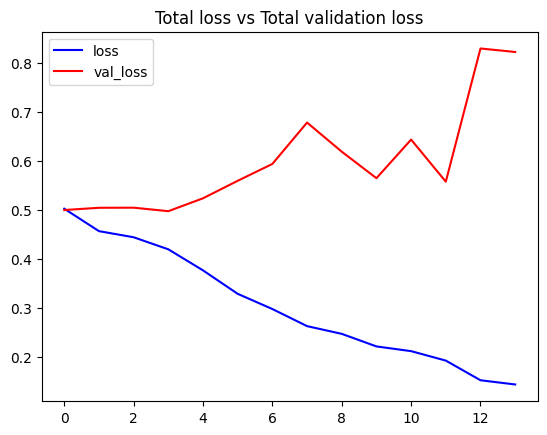

In [24]:
plot_curve(history,'loss','val_loss',"Total loss vs Total validation loss")

In [22]:
predictions = model.predict(x_test)

# Assuming predictions are in probability form and you need to convert them to binary labels
binary_predictions = (predictions > 0.5).astype('int32')

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, binary_predictions, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

W0000 00:00:1713897761.701258    3696 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
Precision: [0.82432432 0.5       ]
Recall: [0.99456522 0.025     ]
F1 Score: [0.90147783 0.04761905]


Confusion Matrix

In [29]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Assuming test_Y is one-hot encoded
conf_matrix = confusion_matrix(true_labels, predicted_labels)

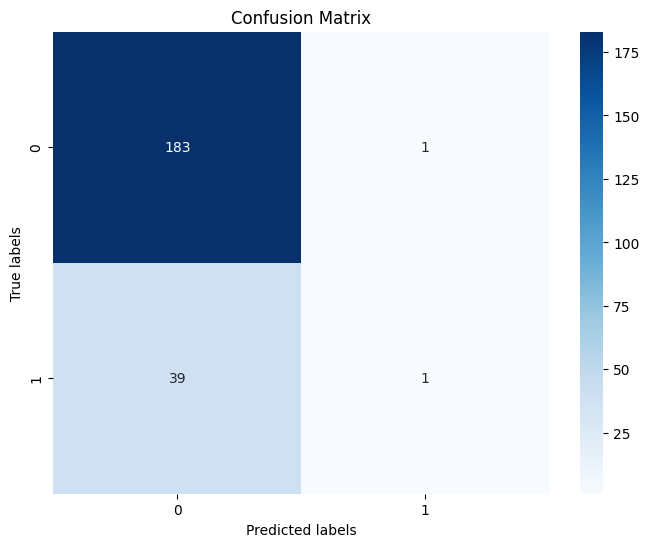

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()